# Process Amazon dataset

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torch
from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

c:\Users\user\anaconda3\envs\sr_gnn_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Sample sessions data

In [3]:
max_limit_num_rows = 500000

In [4]:
training_sessions = pd.read_csv('./sessions_train.csv')
print(training_sessions['locale'].unique())
training_sessions = training_sessions[training_sessions['locale'].isin(['DE','JP','UK'])]
print(training_sessions.describe())
training_sessions['prev_items'] = training_sessions['prev_items'].str.replace('[','').str.replace(']','').str.replace('\'','').str.split()
training_sessions = training_sessions.rename_axis('session_id').reset_index()
training_sessions.head()

['DE' 'JP' 'UK' 'ES' 'FR' 'IT']
                         prev_items   next_item   locale
count                       3272716     3272716  3272716
unique                      2930690      860565        3
top     ['B0BFJGXWDV' 'B0B1MPZWJG']  B014I8T0YQ       UK
freq                            191          90  1182181


,session_id,prev_items,next_item,locale
0,0,"[B09W9FND7K, B09JSPLN1M]",B09M7GY217,DE
1,1,"[B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]",B001B4THSA,DE
2,2,"[B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...",B0767DTG2Q,DE
3,3,"[B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...",B0B4R9NN4B,DE
4,4,"[B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]",B0BGVBKWGZ,DE


In [5]:
target_num_rows_each_group = np.ceil((training_sessions.groupby('locale').count()['session_id']/training_sessions.shape[0])*max_limit_num_rows).astype(int).to_dict()
target_num_rows_each_group

{'DE': 169801, 'JP': 149589, 'UK': 180612}

In [6]:
sample_training_sessions = training_sessions.groupby('locale').apply(lambda group: group.sample(target_num_rows_each_group[group.name], random_state=42)).reset_index(drop = True)
sample_training_sessions.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13724\2610161311.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_training_sessions = training_sessions.groupby('locale').apply(lambda group: group.sample(target_num_rows_each_group[group.name], random_state=42)).reset_index(drop = True)


,session_id,prev_items,next_item,locale
0,638977,"[B09BNVQ361, B0B64YTZVB]",B08W8BGKH5,DE
1,242032,"[B09FPXWK43, B09FPX1Y79, B09FPXWK43, B09FPX1Y7...",B08V5K663S,DE
2,1105915,"[B078SZFJBQ, B078SZ6HRP, B078SY8C5X, B078TDJHY...",B07N44DRRN,DE
3,699613,"[B002F9NTB6, B007KK1MKA, B002F9NTB6, B002F9NTD...",B001R9574M,DE
4,529362,"[B01MSQRXPN, B08ZLYLKJG, B08ZLYLKJG, B098QJPDG...",B099KCZWSZ,DE


In [7]:
sample_training_sessions.shape

(500002, 4)

In [8]:
sample_filtered_products_per_locale = {}
for locale in sample_training_sessions['locale'].unique():
    sample_filtered_products_per_locale[locale] = set(sample_training_sessions[sample_training_sessions['locale']==locale]['prev_items'].explode().tolist()+\
                                                      sample_training_sessions[sample_training_sessions['locale']==locale]['next_item'].tolist())
print({k:len(v) for k,v in sample_filtered_products_per_locale.items()})

{'DE': 285958, 'JP': 226138, 'UK': 282588}


## Process product features

In [9]:
products = pd.read_csv('./products_train.csv')
print(f"number of unique product id: {len(products['id'].unique())}")
print(products['locale'].unique())
print(f"products exist in multiple locale {(products.groupby('id').count()['locale']>1).sum()}")
products = products[products['locale'].isin(['DE','JP','UK'])].reset_index(drop=True)
filtered_products = pd.DataFrame()
for locale,sample_filtered_products in sample_filtered_products_per_locale.items():
    filtered_products = pd.concat([filtered_products, \
                                   products[(products['locale']==locale) & (products['id'].isin(sample_filtered_products))]], \
                                  ignore_index=True)
print(filtered_products['locale'].unique())
print(f"products exist in multiple locale {(filtered_products.groupby('id').count()['locale']>1).sum()}")
filtered_products.index += 1 # set item_id or node_id to start from 1, https://github.com/CRIPAC-DIG/SR-GNN/blob/master/datasets/preprocess.py#L133
product_id2item = filtered_products[['id','locale']].T.to_dict('list')
product_item2id = {tuple(v):k for k, v in product_id2item.items()}
print(filtered_products.shape) # the output size of GNN is the number of products

number of unique product id: 1410675
['DE' 'JP' 'UK' 'ES' 'FR' 'IT']
products exist in multiple locale 99569
['DE' 'JP' 'UK']
products exist in multiple locale 31255
(794684, 11)


In [10]:
filtered_products.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück
5,B08R62WZ1Y,DE,"Kinderkopfhörer Bluetooth, Mädchen Katzenohr K...",24.97,JYPS,Lila,NaN,Kinderkopfhörer,NaN,NaN,🎁Drahtlose und kabelgebundene Kinderkopfhörer:...


In [11]:
max(list(product_id2item.keys()))

794684

In [12]:
import operator
# assert if the max product id match the maximum number of products
assert max(product_id2item.items(), key=operator.itemgetter(0))[0] == max(list(product_id2item.keys()))

In [13]:
# products[products.groupby('id').transform('count')['locale']>1].sort_values(by='id')

In [14]:
# products.describe(include='all')

In [16]:
filtered_products.isnull().sum()

id               0
locale           0
title            5
price            0
brand        10819
color       215793
size        316466
model       401718
material    370505
author      758816
desc         62248
dtype: int64

<Axes: title={'center': 'price'}, xlabel='locale'>

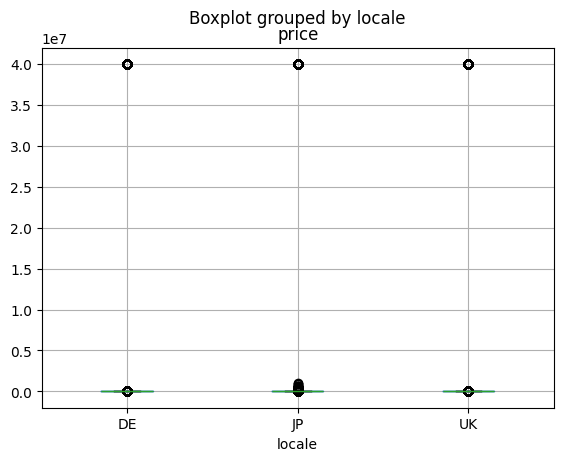

In [17]:
filtered_products.boxplot(column=['price'],by='locale')

In [18]:
filtered_products['price_normalized'] = filtered_products.groupby('locale')['price'].transform(lambda x: (x - x.min()) / (x.max()-x.min()))

In [19]:
text_cols = ['title','author','locale','brand','model','size','color','material','desc']
filtered_products[text_cols] = filtered_products[text_cols].fillna('')

concat_text_template = lambda x: \
'''Product: {title}
Author: {author}
Locale: {locale}
Brand: {brand}
Model: {model}
Size: {size}
Color: {color}
Material: {material}'''.format(**x)

filtered_products = filtered_products.assign(concat_text=filtered_products.apply(concat_text_template, 1))

count    794684.000000
mean         31.123986
std           9.804710
min          10.000000
25%          23.000000
50%          31.000000
75%          38.000000
max         242.000000
Name: concat_text, dtype: float64


<Axes: >

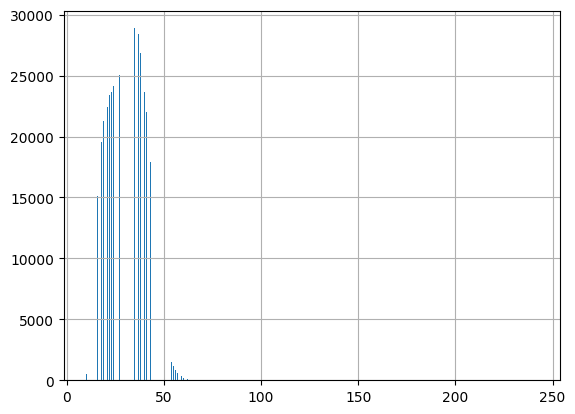

In [20]:
check_concat_text = filtered_products['concat_text'].apply(lambda n: len(n.split()))
print(check_concat_text.describe())
filtered_products['concat_text'].apply(lambda n: len(n.split())).hist(bins=1000)

In [21]:
filtered_products['desc'].head()

1    🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2    3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3    【Auto aufziehbar】: Drücken Sie einfach leicht ...
4                                      Inhalt: 1 Stück
5    🎁Drahtlose und kabelgebundene Kinderkopfhörer:...
Name: desc, dtype: object

In [22]:
text_embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device=device)
text_embed_model.max_seq_length = 256
# embeddings = text_embed_model.encode(products['concat_text'][:10].tolist())
# print(embeddings)

In [23]:
filtered_products_features = np.column_stack((filtered_products['price_normalized'].tolist(),
                                    text_embed_model.encode(filtered_products['concat_text'].tolist(),batch_size=512,device=device,show_progress_bar=True),
                                    text_embed_model.encode(filtered_products['desc'].tolist(),batch_size=512,device=device,show_progress_bar=True),))
filtered_products_features.shape

Batches: 100%|██████████| 1553/1553 [17:10<00:00,  1.51it/s]


(794684, 769)

In [24]:
pickle.dump(filtered_products_features, open('./filtered_products_features.txt', 'wb'))

## Save training sessions dataset

In [25]:
sample_training_sessions['next_item_id'] = pd.Series(zip(sample_training_sessions['next_item'], sample_training_sessions['locale'])).map(product_item2id)
sample_training_sessions['prev_items_id'] = pd.Series([list(map(product_item2id.get, zip(items,[locale]*len(items)))) for items,locale in zip(sample_training_sessions['prev_items'], sample_training_sessions['locale'])]) # Fastest way: https://stackoverflow.com/questions/69548440/map-dictionary-values-to-lists-in-a-pandas-dataframe
sample_training_sessions.head()

,session_id,prev_items,next_item,locale,next_item_id,prev_items_id
0,638977,"[B09BNVQ361, B0B64YTZVB]",B08W8BGKH5,DE,184176,"[62933, 63901]"
1,242032,"[B09FPXWK43, B09FPX1Y79, B09FPXWK43, B09FPX1Y7...",B08V5K663S,DE,162796,"[41717, 35889, 41717, 35889, 41717]"
2,1105915,"[B078SZFJBQ, B078SZ6HRP, B078SY8C5X, B078TDJHY...",B07N44DRRN,DE,243018,"[140004, 152578, 279770, 123114, 245867]"
3,699613,"[B002F9NTB6, B007KK1MKA, B002F9NTB6, B002F9NTD...",B001R9574M,DE,222899,"[105455, 21045, 105455, 258498, 258498, 83988]"
4,529362,"[B01MSQRXPN, B08ZLYLKJG, B08ZLYLKJG, B098QJPDG...",B099KCZWSZ,DE,44317,"[282791, 30579, 30579, 11184, 91840]"


In [26]:
# X_train, X_test, y_train, y_test = train_test_split(training_sessions['prev_items_id'], training_sessions['next_item_id'], test_size=0.33, random_state=42)
# training_set = (X_train.tolist(),y_train.tolist())
# valid_set = (X_test.tolist(),y_test.tolist())
# pickle.dump(training_set, open('./train.txt', 'wb'))
# pickle.dump(valid_set, open('./valid.txt', 'wb'))

training_set = (sample_training_sessions['prev_items_id'].tolist(),sample_training_sessions['next_item_id'].tolist())
pickle.dump(training_set, open('./sample_train.txt', 'wb'))

print(sample_training_sessions['prev_items_id'].shape)

print(len(training_set[0]))
print(len(training_set[1]))
print(len(training_set[0][0]))

# print(len(valid_set[0]))
# print(len(valid_set[1]))
# print(len(valid_set[0][0]))

(500002,)
500002
500002
2


## Save testing sessions dataset

Remove sessions containing product not included in the sample

In [27]:
testing_sessions = pd.read_csv('./sessions_test_task1_phase1.csv')
testing_sessions['prev_items'] = testing_sessions['prev_items'].str.replace('[','').str.replace(']','').str.replace('\'','').str.split()
testing_sessions['check_prev_items'] = pd.Series([np.all(list(map(product_item2id.__contains__, zip(items,[locale]*len(items))))) for items,locale in zip(testing_sessions['prev_items'], testing_sessions['locale'])])
testing_sessions = testing_sessions[testing_sessions['check_prev_items']==True]
testing_sessions['prev_items_id'] = pd.Series([list(map(product_item2id.get, zip(items,[locale]*len(items)))) for items,locale in zip(testing_sessions['prev_items'], testing_sessions['locale'])]) # Fastest way: https://stackoverflow.com/questions/69548440/map-dictionary-values-to-lists-in-a-pandas-dataframe
testing_sessions = testing_sessions.rename_axis('session_id').reset_index()
testing_sessions

,session_id,prev_items,locale,check_prev_items,prev_items_id
0,2,"[B07YSRXJD3, B07G7Q5N6G, B08C9Q7QVK, B07G7Q5N6G]",DE,True,"[204946, 213843, 221159, 247831, 136620, 24169..."
1,3,"[B08KQBYV43, 3955350843, 3955350843, 395535086...",DE,True,"[124302, 39889, 19240, 124302, 23764, 229281]"
2,4,"[B09FPTCWMC, B09FPTQP68, B08HMRY8NG, B08TBBQ4B...",DE,True,"[120368, 126633, 242402, 181331, 56635, 146872..."
3,5,"[B0BHT75TPQ, B0BHT7X2R6, B0BK5VMHND, B0BHT75TP...",DE,True,"[118037, 55104, 241613, 284709]"
4,7,"[B0B8D1V4QW, B0813KJ832, B099XL3VS4, B09V1FW8T...",DE,True,"[167771, 216023]"
...,...,...,...,...,...
248960,316966,"[B077SZ2C3Y, B0B14M3VZX]",UK,True,NaN
248961,316967,"[B08KFHDPY9, B0851KTSRZ, B08KFHDPY9, B0851KTSR...",UK,True,NaN
248962,316968,"[B07PY1N81F, B07Q1Z8SQN, B07PY1N81F, B07Q1Z8SQ...",UK,True,NaN
248963,316969,"[B01MCQMORK, B09JYZ325W]",UK,True,NaN


In [28]:
testing_sessions['locale'].unique()

array(['DE', 'JP', 'UK'], dtype=object)

In [29]:
# testing_sessions.to_csv('./drive/MyDrive/MSBD 5008/sessions_test_task1_phase1_srgnn.csv',index=False)
testing_set = (testing_sessions['prev_items_id'].tolist(),[])
pickle.dump(testing_set, open('./sample_test.txt', 'wb'))